# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone. 

Data: https://archive.ics.uci.edu/dataset/222/bank+marketing



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [1]:
import time
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split



In [2]:
df = pd.read_csv('data/bank-additional-full.csv', sep = ';')

In [3]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



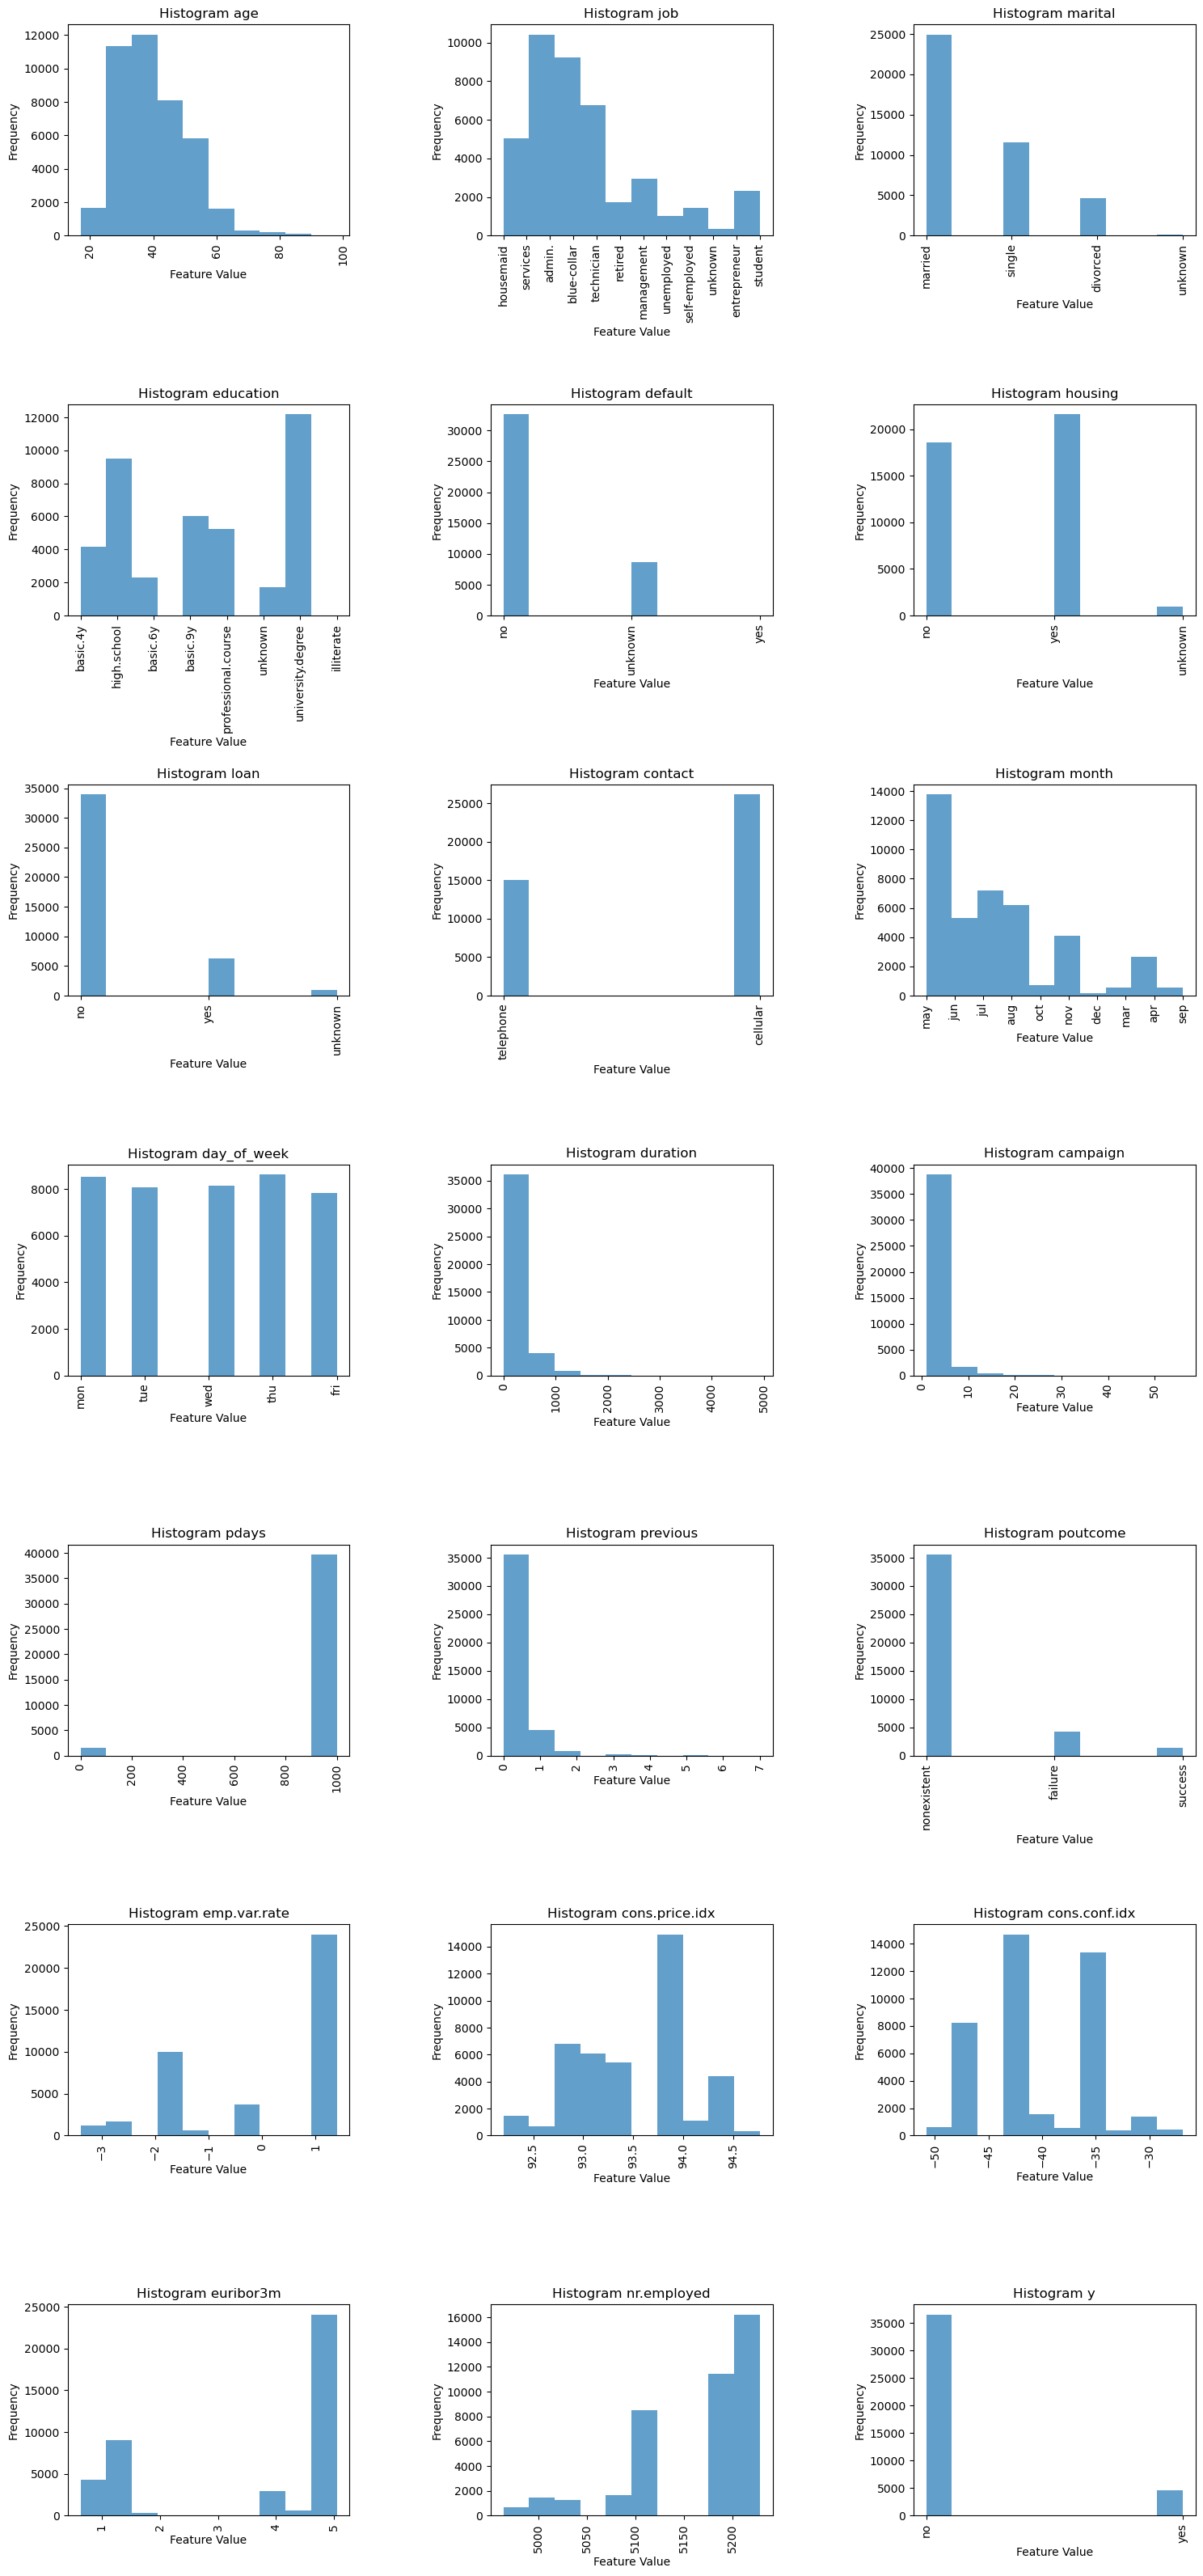

In [4]:

fig, axs = plt.subplots(7, 3, figsize=(18, 40))

for ax, column in zip(axs.flat, df.columns):
    ax.hist(df[[column]], alpha=0.7)
    ax.set_title(f'Histogram {column}')
    ax.set_xlabel('Feature Value')
    ax.set_ylabel('Frequency')
    for label in ax.get_xticklabels():
        label.set_rotation(90)

plt.subplots_adjust(hspace=0.8, wspace=0.5)
plt.show()

/var/folders/87/pfsc8m451637m7_w53vddp540000gn/T/ipykernel_9876/58359773.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr())


<Axes: >

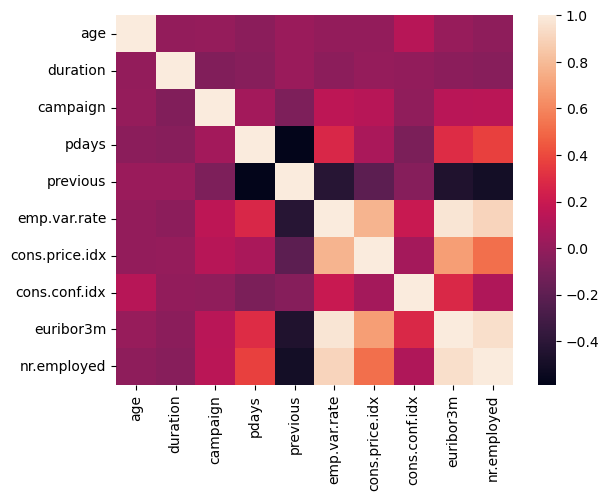

In [5]:
sns.heatmap(df.corr())

In [6]:
# Drop all unknown values
df_clean = df[~df.isin(['unknown']).any(axis=1)]

# Convert to binary
binary_columns = ['default', 'housing', 'loan', 'y']
df_clean[binary_columns] = df_clean[binary_columns].replace({'yes': 1, 'no': 0})

df_clean.select_dtypes(['object'])


/var/folders/87/pfsc8m451637m7_w53vddp540000gn/T/ipykernel_9876/2213335400.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean[binary_columns] = df_clean[binary_columns].replace({'yes': 1, 'no': 0})


,job,marital,education,contact,month,day_of_week,poutcome
0,housemaid,married,basic.4y,telephone,may,mon,nonexistent
2,services,married,high.school,telephone,may,mon,nonexistent
3,admin.,married,basic.6y,telephone,may,mon,nonexistent
4,services,married,high.school,telephone,may,mon,nonexistent
6,admin.,married,professional.course,telephone,may,mon,nonexistent
...,...,...,...,...,...,...,...
41183,retired,married,professional.course,cellular,nov,fri,nonexistent
41184,blue-collar,married,professional.course,cellular,nov,fri,nonexistent
41185,retired,married,university.degree,cellular,nov,fri,nonexistent
41186,technician,married,professional.course,cellular,nov,fri,nonexistent


#### Business Objective
The business objective is to optimize the bank's marketing campaigns by accurately predicting which clients are likely to subscribe to term deposits. This will increase conversion, improve customer targeting and reduce operational costs.


### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features (columns 1 - 7), prepare the features and target column for modeling with appropriate encoding and transformations.

In [7]:
df_model = df_clean[df_clean.columns[:7].to_list() + ['y']]
df_model

,age,job,marital,education,default,housing,loan,y
0,56,housemaid,married,basic.4y,0,0,0,0
2,37,services,married,high.school,0,1,0,0
3,40,admin.,married,basic.6y,0,0,0,0
4,56,services,married,high.school,0,0,1,0
6,59,admin.,married,professional.course,0,0,0,0
...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,0,1,0,1
41184,46,blue-collar,married,professional.course,0,0,0,0
41185,56,retired,married,university.degree,0,1,0,0
41186,44,technician,married,professional.course,0,0,0,1


### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [8]:
# Splitting the dataset into training and testing set
X = df_model.drop('y', axis=1)
y = df_model['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [9]:
numeric_features = ['age']
categorical_features = ['job', 'marital', 'education']
binary_features = ['default', 'housing', 'loan']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features),
        ('bin', 'passthrough', binary_features)
    ])

### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

Test Accuracy: 0.8698, Train Accuracy: 0.8743, Fit Time: 0.2920701503753662


<BarContainer object of 25 artists>

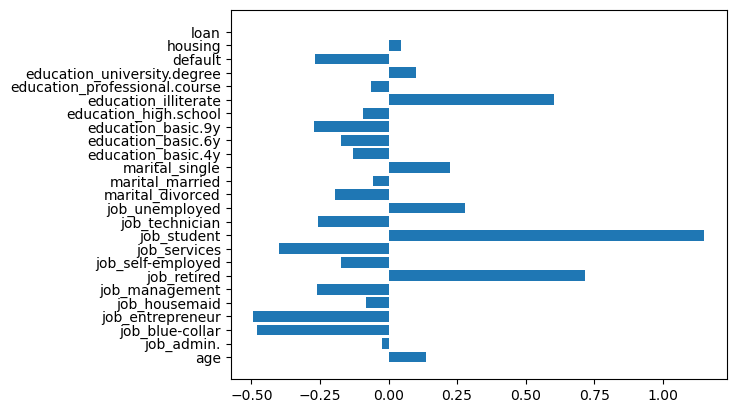

In [15]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                            ('classifier', LogisticRegression())])

start_time = time.time()
pipeline.fit(X_train, y_train)
Logistic_regression_fit_time = time.time() - start_time

# Predictions
y_test_pred = pipeline.predict(X_test)
y_train_pred = pipeline.predict(X_train)

# Evaluation
Logistic_regression_test_accuracy = accuracy_score(y_test, y_test_pred)
Logistic_regression_train_accuracy = accuracy_score(y_train, y_train_pred)

# Display results
print(f"Test Accuracy: {Logistic_regression_test_accuracy:.4f}, Train Accuracy: {Logistic_regression_train_accuracy:.4f}, Fit Time: {Logistic_regression_fit_time}")

# For Logistic Regression (assuming binary classification for simplicity)
feature_names = numeric_features + \
                list(pipeline.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_features)) + \
                binary_features
coeffs = pipeline.named_steps['classifier'].coef_[0]
feature_coefficients = dict(zip(feature_names, coeffs))

plt.barh(feature_names, coeffs)

In [16]:
# Create and fit the pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                            ('classifier', KNeighborsClassifier())])
pipeline.fit(X_train, y_train)

start_time = time.time()
pipeline.fit(X_train, y_train)
KNN_fit_time = time.time() - start_time

# Predictions
y_test_pred = pipeline.predict(X_test)
y_train_pred = pipeline.predict(X_train)

# Evaluation
KNN_test_accuracy = accuracy_score(y_test, y_test_pred)
KNN_train_accuracy = accuracy_score(y_train, y_train_pred)

# Display results
print(f"Test Accuracy: {KNN_test_accuracy:.4f}, Train Accuracy: {KNN_train_accuracy:.4f}, Fit Time: {KNN_fit_time}")



Test Accuracy: 0.8595, Train Accuracy: 0.8740, Fit Time: 0.06394219398498535


In [17]:
# Create and fit the pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                            ('classifier', DecisionTreeClassifier())])
pipeline.fit(X_train, y_train)

start_time = time.time()
pipeline.fit(X_train, y_train)
Decision_tree_fit_time = time.time() - start_time

# Predictions
y_test_pred = pipeline.predict(X_test)
y_train_pred = pipeline.predict(X_train)

# Evaluation
Decision_tree_test_accuracy = accuracy_score(y_test, y_test_pred)
Decision_tree_train_accuracy = accuracy_score(y_train, y_train_pred)

# Display results
print(f"Test Accuracy: {Decision_tree_test_accuracy:.4f}, Train Accuracy: {Decision_tree_train_accuracy:.4f}, Fit Time: {Decision_tree_fit_time}")

# For models with feature_importances_ like Decision Trees
print("Feature Importances:")
print(pipeline.named_steps['classifier'].feature_importances_)

Test Accuracy: 0.8513, Train Accuracy: 0.9017, Fit Time: 0.713813066482544
Feature Importances:
[4.53786422e-01 9.04269562e-03 1.61871734e-02 1.32314841e-02
 1.51811306e-02 1.99287674e-02 8.22181992e-03 8.91245366e-03
 1.43626085e-02 2.55990529e-02 1.90288039e-02 9.60701437e-03
 2.65257252e-02 3.47750217e-02 1.74208688e-02 1.53082167e-02
 1.26810350e-02 1.99802783e-02 3.28387465e-02 6.23078453e-04
 2.42036767e-02 1.67400371e-02 8.41450479e-06 1.04070179e-01
 8.17352954e-02]


In [18]:
# Create and fit the pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                            ('classifier', SVC())])
pipeline.fit(X_train, y_train)

start_time = time.time()
pipeline.fit(X_train, y_train)
SVC_fit_time = time.time() - start_time

# Predictions
y_test_pred = pipeline.predict(X_test)
y_train_pred = pipeline.predict(X_train)

# Evaluation
SVC_test_accuracy = accuracy_score(y_test, y_test_pred)
SVC_train_accuracy = accuracy_score(y_train, y_train_pred)

# Display results
print(f"Test Accuracy: {SVC_test_accuracy:.4f}, Train Accuracy: {SVC_train_accuracy:.4f}, Fit Time: {SVC_fit_time}")

Test Accuracy: 0.8698, Train Accuracy: 0.8743, Fit Time: 38.74075508117676


### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:




In [19]:
model_performance = pd.DataFrame({
    "model": ["Logistic Regression", "KNN", "Decision Tree", "SVM"],
    "fit time": [Logistic_regression_fit_time, KNN_fit_time, Decision_tree_fit_time, SVC_fit_time],
    "train accuracy": [Logistic_regression_train_accuracy, KNN_train_accuracy, Decision_tree_train_accuracy, SVC_train_accuracy],
    "test accuracy": [Logistic_regression_test_accuracy, KNN_test_accuracy, Decision_tree_test_accuracy, SVC_test_accuracy]
})
model_performance

,model,fit time,train accuracy,test accuracy
0,Logistic Regression,0.292070,0.874334,0.869793
1,KNN,0.063942,0.874006,0.859462
2,Decision Tree,0.713813,0.901681,0.851263
3,SVM,38.740755,0.874334,0.869793


### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

##### Questions